#TensorFlow Cloud - Putting it all together
In this example, we will use all of the features outlined in the [Keras cloud guide]() to train a state-of-the-art model to classify dog breeds using feature extraction. Let's begin by installing TensorFlow Cloud and importing a few important packages.

##Setup

In [ ]:
!pip install -q tensorflow-cloud

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_cloud as tfc
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

###Cloud Configuration

In order to run TensorFlow Cloud from a Colab notebook, we'll need to upload our [authentication key]() and specify our [Cloud storage bucket]() for image building and publishing. 

In [ ]:
if not tfc.remote():   
  from google.colab import files

  key_upload = files.upload()
  key_path = list(key_upload.keys())[0]
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
  os.system(f"gcloud auth activate-service-account --key-file {key_path}")

In [7]:
# GCP_BUCKET = "your-bucket-name"
GCP_BUCKET = "keras-examples-jonah"

##Model Creation

###Dataset preprocessing
We'll be loading our training data from TensorFlow Datasets: 

In [ ]:
(ds_train, ds_test), metadata = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)
 
NUM_CLASSES = metadata.features["label"].num_classes

Lets visualize this dataset:

In [ ]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(ds_train))
print("Number of test samples: %d" % tf.data.experimental.cardinality(ds_test))
print("Number of classes: %d" % NUM_CLASSES)

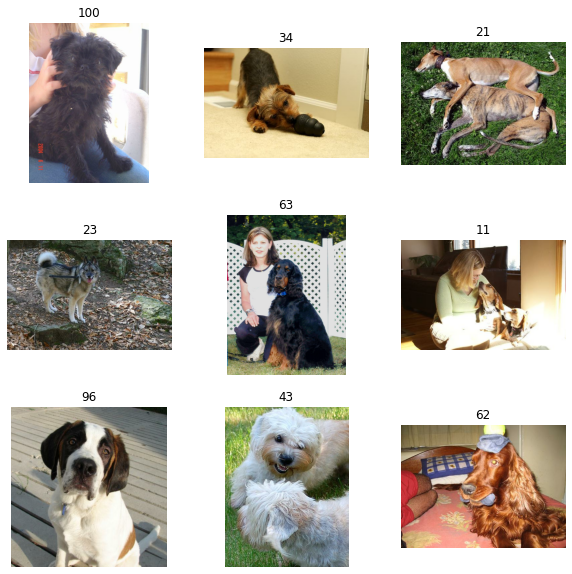

In [10]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Here we will resize and rescale our images to fit into our model's input, as well as create batches. 

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64
BUFFER_SIZE = 2
 
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
 
def input_preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [12]:
ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
 
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
 
ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

###Model Architecture
We're using ResNet50 pretrained on ImageNet, from the Keras Applications module. 

In [14]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = tf.keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_tensor=inputs
)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES)(x)
 
model = tf.keras.Model(inputs, outputs)

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
base_model.trainable = False

###Callbacks using Cloud Storage

In [16]:
MODEL_PATH = "resnet-dogs"
checkpoint_path = os.path.join("gs://", GCP_BUCKET, MODEL_PATH, "save_at_{epoch}")
tensorboard_path = os.path.join(
    "gs://", GCP_BUCKET, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

callbacks = [
    # TensorBoard will store logs for each epoch and graph performance for us. 
    keras.callbacks.TensorBoard(log_dir=tensorboard_path, histogram_freq=1),
    # ModelCheckpoint will save models after each epoch for retrieval later.
    keras.callbacks.ModelCheckpoint(checkpoint_path),
    # EarlyStopping will terminate training when val_loss ceases to improve. 
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Here, we're using the `tfc.remote()` flag to designate a smaller number of epochs than intended for the full training job when running locally. This enables easy debugging on Colab.

In [18]:
if tfc.remote():
    epochs = 500
    train_data = ds_train
    test_data = ds_test
else:
    epochs = 1
    train_data = ds_train.take(5)
    test_data = ds_test.take(5)
    callbacks = None
 
model.fit(
    train_data, epochs=epochs, callbacks=callbacks, validation_data=test_data, verbose=2
)

5/5 - 92s - loss: 11.9617 - accuracy: 0.0344 - val_loss: 10.4087 - val_accuracy: 0.0688


In [ ]:
if tfc.remote():
    SAVE_PATH = os.path.join("gs://", GCP_BUCKET, MODEL_PATH)
    model.save(SAVE_PATH)

Our model requires two additional libraries. We'll create a `requirements.txt` which specifies those libraries:

In [19]:
requirements = ["tensorflow-datasets", "matplotlib"]

f = open("requirements.txt", 'w')
f.write('\n'.join(requirements))
f.close()

Let's add some job labels so we can document our job logs later:

In [20]:
job_labels = {"job":"resnet-dogs", "team":"keras-io", "user":"jonah"}

###Train on Cloud

All that's left to do is run our model on Cloud. To recap, our `run()` call enables:
- A model that will be trained and stored on Cloud, including checkpoints
- Tensorboard callback logs that will be accessible through tensorboard.dev
- Specific python library requirements that will be fulfilled
- Customizable job labels for log documentation
- Real-time streaming logs printed in Colab
- Deeply customizable machine configuration (ours will use two Tesla T4s)
- An automatic resolution of distribution strategy for this configuration

In [ ]:
tfc.run(
    requirements_txt="requirements.txt",
    distribution_strategy="auto",
    chief_config=tfc.MachineConfig(
        cpu_cores=8,
        memory=30,
        accelerator_type=tfc.AcceleratorType.NVIDIA_TESLA_T4,
        accelerator_count=2,
    ),
    docker_image_bucket_name=GCP_BUCKET,
    job_labels=job_labels,
    stream_logs=True,
    
)

###Evaluate your model

We'll use the cloud storage directories we saved for callbacks in order to load tensorboard and retrieve the saved model. Tensorboard logs can be used to monitor training performance in real-time

In [ ]:
!tensorboard dev upload --logdir "gs://keras-examples-jonah/logs" --name "ResNet Dogs"

In [ ]:
if tfc.remote():
    model = tf.keras.models.load_model(SAVE_PATH)
model.evaluate(test_data)